In [1]:
# Import libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim
from skimage import data

# For deep learning models
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, InputLayer, Add
from tensorflow.keras.optimizers import Adam


In [2]:
# Display and downsample utility functions
def display_images(images, titles, figsize=(15, 5)):
    """
    Display a list of images with titles.
    """
    plt.figure(figsize=figsize)
    for i, (image, title) in enumerate(zip(images, titles)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(image, cmap='gray' if image.ndim == 2 else None)
        plt.title(title)
        plt.axis('off')
    plt.tight_layout()
    plt.show()

def downsample_image(image, scale=2):
    """
    Downsamples the given image by the specified scale.
    """
    h, w = image.shape[:2]
    low_res = resize(image, (h // scale, w // scale), anti_aliasing=True)
    return resize(low_res, (h, w), anti_aliasing=True)


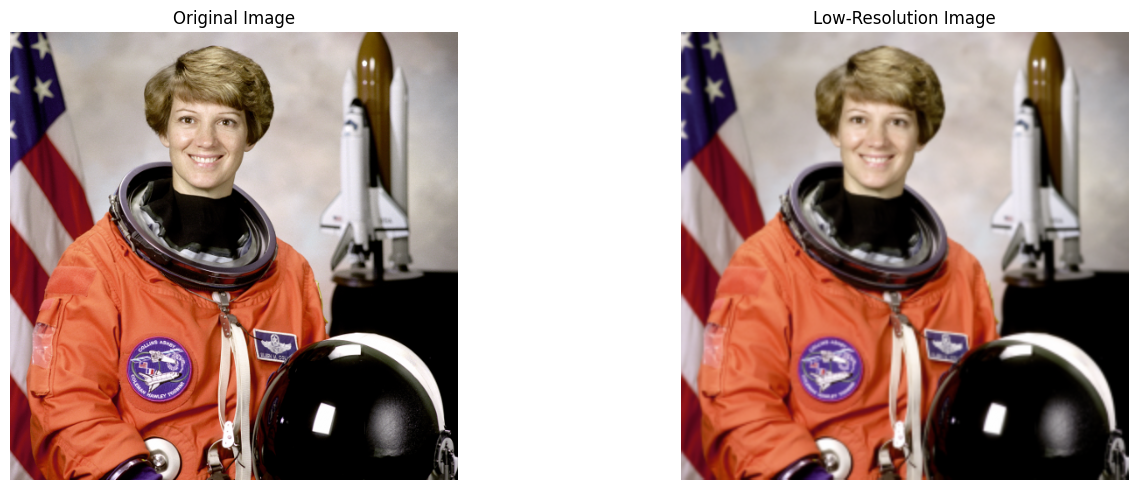

In [3]:
# Load and downsample the image
original_image = data.astronaut() / 255.0  # Normalize to [0, 1]
low_res_image = downsample_image(original_image, scale=2)

# Display images
display_images([original_image, low_res_image], ["Original Image", "Low-Resolution Image"])


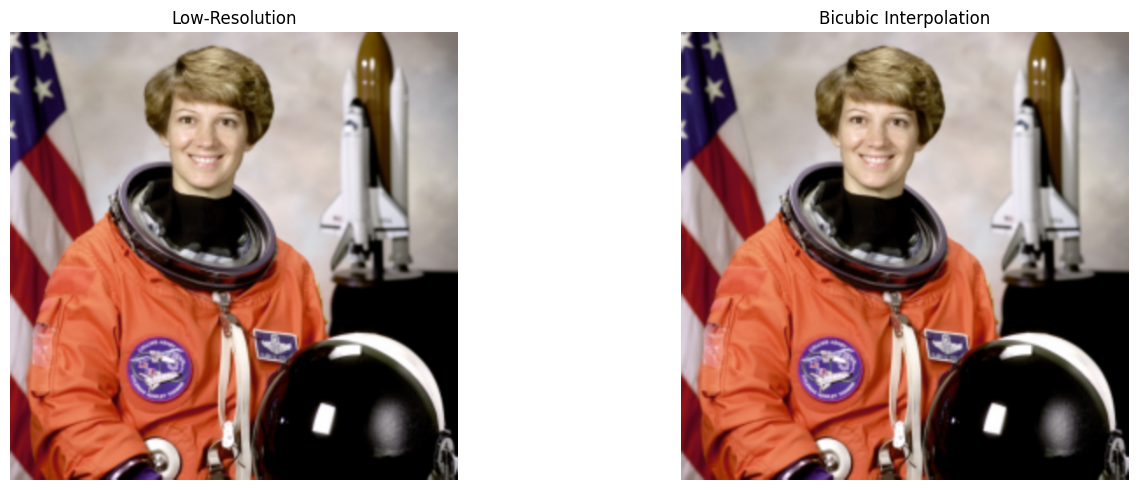

In [4]:
# Bicubic interpolation for super-resolution
bicubic_image = resize(low_res_image, original_image.shape[:2], anti_aliasing=True, order=3)

# Display bicubic result
display_images([low_res_image, bicubic_image], ["Low-Resolution", "Bicubic Interpolation"])


In [5]:
# Define SRCNN model
def build_SRCNN(input_shape):
    """
    Build a simple SRCNN model for super-resolution.
    """
    model = Sequential([
        InputLayer(input_shape=input_shape),
        Conv2D(64, (9, 9), activation='relu', padding='same'),
        Conv2D(32, (5, 5), activation='relu', padding='same'),
        Conv2D(3, (5, 5), activation='linear', padding='same')
    ])
    return model

# Build and compile SRCNN
srcnn = build_SRCNN(input_shape=low_res_image.shape)
srcnn.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
srcnn.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 512, 512, 64)        │          15,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 512, 512, 32)        │          51,232 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 512, 512, 3)         │           2,403 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 69,251 (270.51 KB)

 Trainable params: 69,251 (270.51 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
# Train SRCNN with a single image pair for demonstration
x_train = np.expand_dims(low_res_image, axis=0)
y_train = np.expand_dims(original_image, axis=0)

# Training SRCNN
srcnn.fit(x_train, y_train, epochs=5, batch_size=1, verbose=0)  # Fewer epochs for demonstration


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 805ms/step


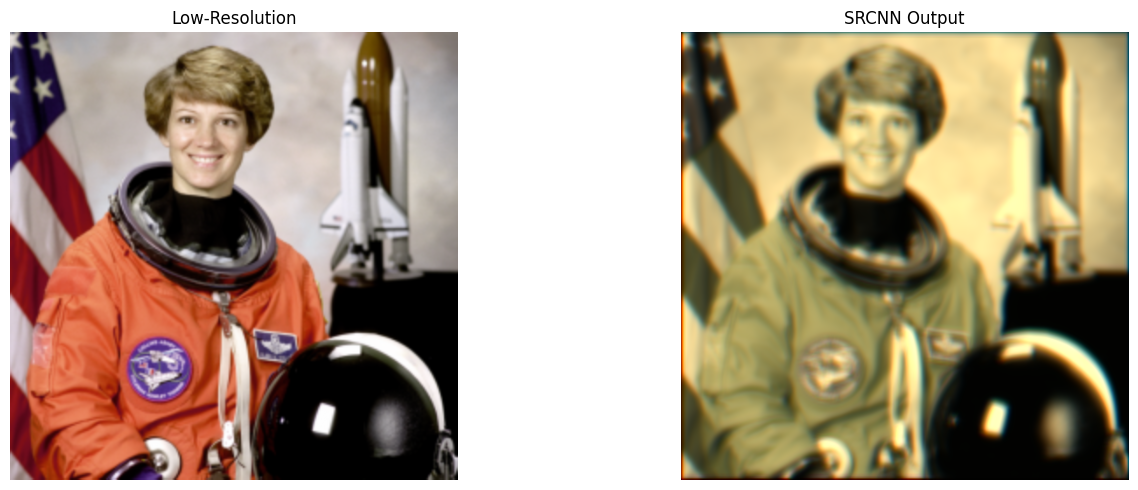

In [11]:
# Predict the high-resolution image using SRCNN
srcnn_output = srcnn.predict(x_train)[0
                                ]

# Display SRCNN result
display_images([low_res_image, srcnn_output], ["Low-Resolution", "SRCNN Output"])


Bicubic PSNR: 28.59, SSIM: 0.87
SRCNN PSNR: 16.15, SSIM: 0.61


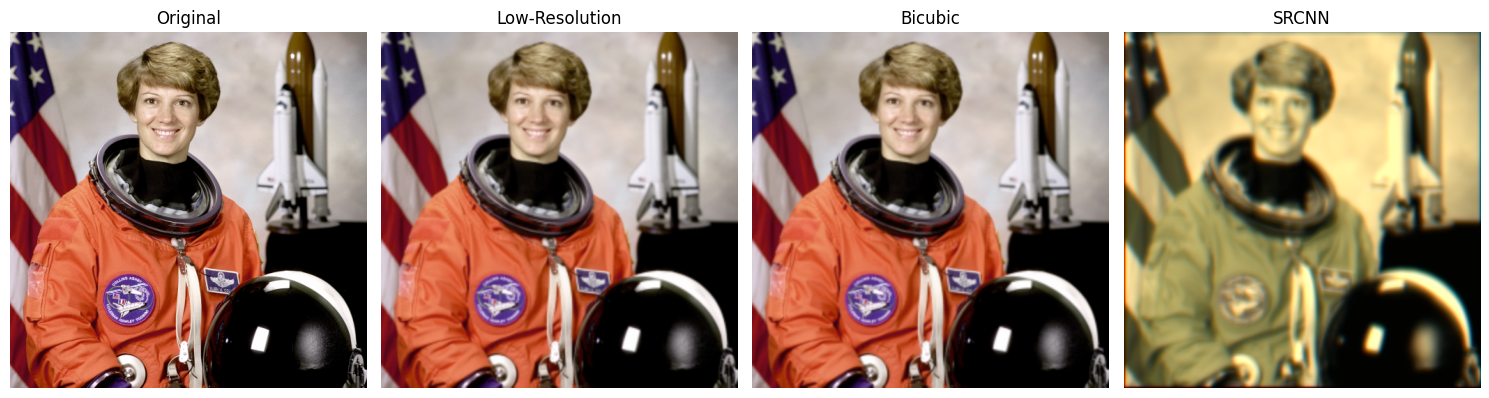

In [15]:
# Metrics for evaluation
bicubic_psnr = psnr(original_image, bicubic_image, data_range=1.0)
srcnn_psnr = psnr(original_image, srcnn_output, data_range=1.0)

# Explicitly define win_size and data_range for SSIM
bicubic_ssim = ssim(original_image, bicubic_image, win_size=3, data_range=1.0, channel_axis=-1)
srcnn_ssim = ssim(original_image, srcnn_output, win_size=3, data_range=1.0, channel_axis=-1)

# Print metrics
print(f"Bicubic PSNR: {bicubic_psnr:.2f}, SSIM: {bicubic_ssim:.2f}")
print(f"SRCNN PSNR: {srcnn_psnr:.2f}, SSIM: {srcnn_ssim:.2f}")

# Display all results
display_images(
    [original_image, low_res_image, bicubic_image, srcnn_output],
    ["Original", "Low-Resolution", "Bicubic", "SRCNN"]
)
